In [1]:
%tensorflow_version 1.x
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

from keras.layers import Input, Dense, Lambda, InputLayer, concatenate
from keras.models import Model, Sequential
from keras import backend as K
from keras import metrics
from keras.datasets import mnist
from keras.utils import np_utils

TensorFlow 1.x selected.


Using TensorFlow backend.


In [147]:
from keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

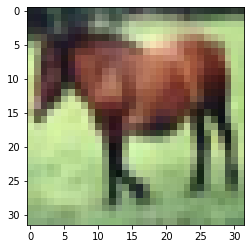

In [148]:
plt.imshow(x_train[7, :])
plt.show()

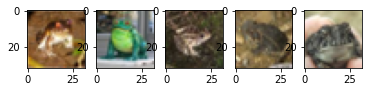

In [149]:
fig, ax = plt.subplots(1, 5)

n = 0
for j in range(len(x_train)):
  if y_train[j][0] == 6:
    ax[n].imshow(x_train[j, :])
    n +=1
    if n == 5:
      break

In [200]:
def vlb_gaussian(x, x_decoded_mean, t_mean, t_log_var):
    """Returns the value of negative Variational Lower Bound
    
    The inputs are tf.Tensor
        x: (batch_size x number_of_pixels) matrix with one image per row with zeros and ones
        x_decoded_mean: (batch_size x number_of_pixels) mean of the distribution p(x | t), real numbers from 0 to 1
        t_mean: (batch_size x latent_dim) mean vector of the (normal) distribution q(t | x)
        t_log_var: (batch_size x latent_dim) logarithm of the variance vector of the (normal) distribution q(t | x)
    
    Returns:
        A tf.Tensor with one element (averaged across the batch), VLB
    """

    # VLB = Sum_i( Expected_q_i( log( px_i | t_i, w ) ) - KL( q_i(t_i) || p(t_i) ))
    # First let's do KL(q||p) = Expected_q_i(log(q/p)) = Expected_q_i(-log(p/q))
    kl_inner = 0.5*(-t_log_var + tf.exp(t_log_var) + t_mean**2 - 1)
    # Now mean on the dimension axis per image
    kl = tf.reduce_sum(kl_inner, axis = 1)
    kl = tf.reduce_mean(kl)

    # Now let's do the first term, which reduces to Expected_q_i(log(p(x_i|t_i,w)))
    recloss_inner = tf.math.squared_difference(Flatten()(x), Flatten()(x_decoded_mean))
    recloss = tf.reduce_sum(recloss_inner, 1)
    recloss = tf.reduce_mean(recloss)

    VLB = recloss + kl

    return VLB

In [233]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Reshape, Conv2DTranspose

batch_size = 100
num_channels = 3
image_size = 32 # Number of pixels in MNIST images.
latent_dim = 1024 # d, dimensionality of the latent code t.
intermediate_dim = 256 # Size of the hidden layer.
epochs = 3

x = Input(batch_shape=(batch_size, image_size, image_size, num_channels))
def create_encoder(input_dim, num_channels):
    # Encoder network.
    # We instantiate these layers separately so as to reuse them later
    encoder = Sequential(name='encoder')
    encoder.add(InputLayer([input_dim, input_dim, num_channels]))

    encoder.add(Conv2D(64, 4, strides=2, padding='same', activation=tf.nn.relu))
    encoder.add(Conv2D(128, 4, strides=2, padding='same', activation=tf.nn.relu))
    encoder.add(Conv2D(512, 4, strides=2, padding='same', activation=tf.nn.relu))

    encoder.add(Flatten())
    encoder.add(Dense(2 * latent_dim))

    return encoder

encoder = create_encoder(image_size, num_channels)

get_t_mean = Lambda(lambda h: h[:, :latent_dim])
get_t_log_var = Lambda(lambda h: h[:, latent_dim:])
h = encoder(x)
t_mean = get_t_mean(h)
t_log_var = get_t_log_var(h)

# Sampling from the distribution 
#     q(t | x) = N(t_mean, exp(t_log_var))
# with reparametrization trick.
def sampling(args):
    """Returns sample from a distribution N(args[0], diag(args[1]))
    
    The sample should be computed with reparametrization trick.
    
    The inputs are tf.Tensor
        args[0]: (batch_size x latent_dim) mean of the desired distribution
        args[1]: (batch_size x latent_dim) logarithm of the variance vector of the desired distribution
    
    Returns:
        A tf.Tensor of size (batch_size x latent_dim), the samples.
    """
    t_mean, t_log_var = args

    eps = tf.random.normal(
      t_mean.shape, mean=0.0, stddev=1.0, dtype=tf.dtypes.float32
    )
    t = tf.multiply(eps, tf.exp(0.5 * t_log_var)) + t_mean
    return t



t = Lambda(sampling)([t_mean, t_log_var])
print(t.shape)

def create_decoder(input_dim):
    # Decoder network
    # We instantiate these layers separately so as to reuse them later
    decoder = Sequential(name='decoder')
    decoder.add(InputLayer(input_shape=(input_dim,)))
    decoder.add(Dense(4*4*128))
    decoder.add(Reshape(target_shape=(4, 4, 128)))
    decoder.add(Conv2DTranspose(256, 4, strides=2, padding='same', activation=tf.nn.relu))
    decoder.add(Conv2DTranspose(64, 4, strides=2, padding='same', activation=tf.nn.relu))
    decoder.add(Conv2DTranspose(3, 4, strides=2, padding='same', activation='sigmoid'))

    return decoder

decoder = create_decoder(latent_dim)
x_decoded_mean = decoder(t)

(100, 1024)


In [202]:
# One hot encoding.
# y_train = np_utils.to_categorical(y_train)
# y_test = np_utils.to_categorical(y_test)

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
# x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
# x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [208]:
loss = vlb_gaussian(x, x_decoded_mean, t_mean, t_log_var)
vae = Model(x, x_decoded_mean)
# Keras will provide input (x) and output (x_decoded_mean) to the function that
# should construct loss, but since our function also depends on other
# things (e.g. t_means), it is easier to build the loss in advance and pass
# a function that always returns it.
vae.compile(optimizer='adam', loss=lambda x, y: loss)

hist = vae.fit(x=x_train, y=x_train,
               shuffle=True,
               epochs=40,
               batch_size=batch_size,
               validation_data=(x_test, x_test),
               verbose=2)

Train on 50000 samples, validate on 10000 samples
Epoch 1/40


KeyboardInterrupt: ignored

In [204]:
# Start tf session so we can run code.
sess = tf.InteractiveSession()
# Connect keras to the created session.
tf.keras.backend.set_session(sess)

init = tf.global_variables_initializer()
sess.run(init)

/tensorflow-1.15.2/python3.6/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


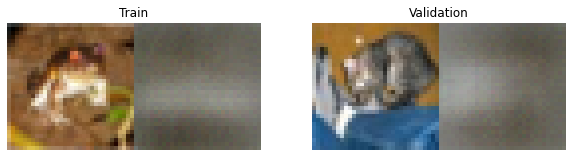

In [209]:
image_size = 32
num_channels = 3

fig = plt.figure(figsize=(10, 10))
for fid_idx, (data, title) in enumerate(zip([x_train, x_test], ['Train', 'Validation'])):
    n = 1  # figure with 10 x 2 digits
    figure = np.zeros((image_size * n, image_size * 2, num_channels))
    decoded = sess.run(x_decoded_mean, feed_dict={x: data[:batch_size, :]})
    for i in range(n):
        # figure[i * image_size: (i + 1) * image_size,:image_size] = data[i, :].reshape(image_size, image_size, num_channels)
        # figure[i * image_size: (i + 1) * image_size,image_size:] = decoded[i, :].reshape(image_size, image_size, num_channels)
        figure[i * image_size: (i + 1) * image_size,:image_size,:] = data[i, :].reshape(image_size, image_size, num_channels)
        figure[i * image_size: (i + 1) * image_size,image_size:,:] = decoded[i, :].reshape(image_size, image_size, num_channels)
    ax = fig.add_subplot(1, 2, fid_idx + 1)
    ax.imshow(figure, cmap='Greys_r')
    ax.set_title(title)
    ax.axis('off')
plt.show()

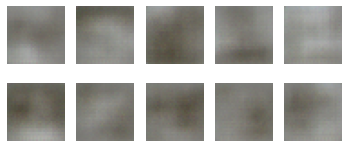

In [212]:
n_samples = 10  # To pass automatic grading please use at least 2 samples here.
# YOUR CODE HERE.
t = tf.random.normal(
  (n_samples, latent_dim), mean=0.0, stddev=1.0, dtype=tf.dtypes.float32
)
# sampled_im_mean is a tf.Tensor of size 10 x 784 with 10 random
# images sampled from the vae model.
sampled_im_mean = decoder(t)

sampled_im_mean_np = sess.run(sampled_im_mean)
# Show the sampled images.
plt.figure()
for i in range(n_samples):
    ax = plt.subplot(n_samples // 5 + 1, 5, i + 1)
    plt.imshow(sampled_im_mean_np[i, :].reshape(image_size, image_size, num_channels))#, cmap='gray')
    ax.axis('off')
plt.show()

In [325]:
from keras.layers import Reshape

# One-hot labels placeholder.
num_classes = 10

x = Input(batch_shape=(batch_size, image_size, image_size, num_channels))
_label = Input(batch_shape=(batch_size, 1))

label_reshape_lambda = lambda z: keras.backend.one_hot(keras.backend.cast(z, tf.int64), num_classes)[:,0,:]
_label_one_hot = Lambda(label_reshape_lambda)(_label)

label_reshape = lambda z: Reshape([1, 1, num_classes])(z) * keras.backend.ones([batch_size, image_size, image_size, num_classes])
label = Lambda(label_reshape)(_label_one_hot)

# YOUR CODE HERE.
cond_enc_input = concatenate([x, label])
cond_encoder = create_encoder(image_size, num_channels + 10)(cond_enc_input)

cond_t_mean = get_t_mean(cond_encoder) # Mean of the latent code (without label) for cvae model.
cond_t_log_var = get_t_log_var(cond_encoder) # Logarithm of the variance of the latent code (without label) for cvae model.

t = Lambda(sampling)([cond_t_mean, cond_t_log_var])

decoder = create_decoder(latent_dim + num_classes)
cond_dec_input = concatenate([t, keras.backend.cast(_label_one_hot, tf.float32)])

cond_x_decoded_mean = decoder(cond_dec_input) # Final output of the cvae model.

In [ ]:
y_train = y_train.reshape(y_train.shape[0])
y_test = y_test.reshape(y_test.shape[0])

conditional_loss = vlb_gaussian(x, cond_x_decoded_mean, cond_t_mean, cond_t_log_var)
cvae = Model([x, _label], cond_x_decoded_mean)
cvae.compile(optimizer='adam', loss=lambda x, y: conditional_loss)

In [336]:
hist = cvae.fit(x=[x_train, y_train],
                y=x_train,
                shuffle=True,
                epochs=epochs*5,
                batch_size=batch_size,
                validation_data=([x_test, y_test], x_test),
                verbose=2)

Train on 50000 samples, validate on 10000 samples
Epoch 1/15
 - 41s - loss: 80.8176 - val_loss: 81.2353
Epoch 2/15
 - 41s - loss: 80.5875 - val_loss: 80.8237
Epoch 3/15


KeyboardInterrupt: ignored

In [337]:
# Prepare one hot labels of form
#   0 0 0 0 0 1 1 1 1 1 2 2 2 2 2 ...
# to sample five zeros, five ones, etc
curr_labels = np.eye(10)
curr_labels = np.repeat(curr_labels, 5, axis=0)  # Its shape is 50 x 10.
# YOUR CODE HERE.
for j in range(len(curr_labels)):
  curr_labels[j] = (j // 10) * curr_labels[j]
curr_labels = tf.convert_to_tensor(curr_labels, dtype=tf.float32)

t = tf.random.normal(
  (50, latent_dim), mean=0.0, stddev=1.0, dtype=tf.dtypes.float32
)
dec_input = concatenate([t, curr_labels])

# cond_sampled_im_mean is a tf.Tensor of size 50 x 784 with 5 random zeros,
# then 5 random ones, etc sampled from the cvae model.
cond_sampled_im_mean = decoder(dec_input)

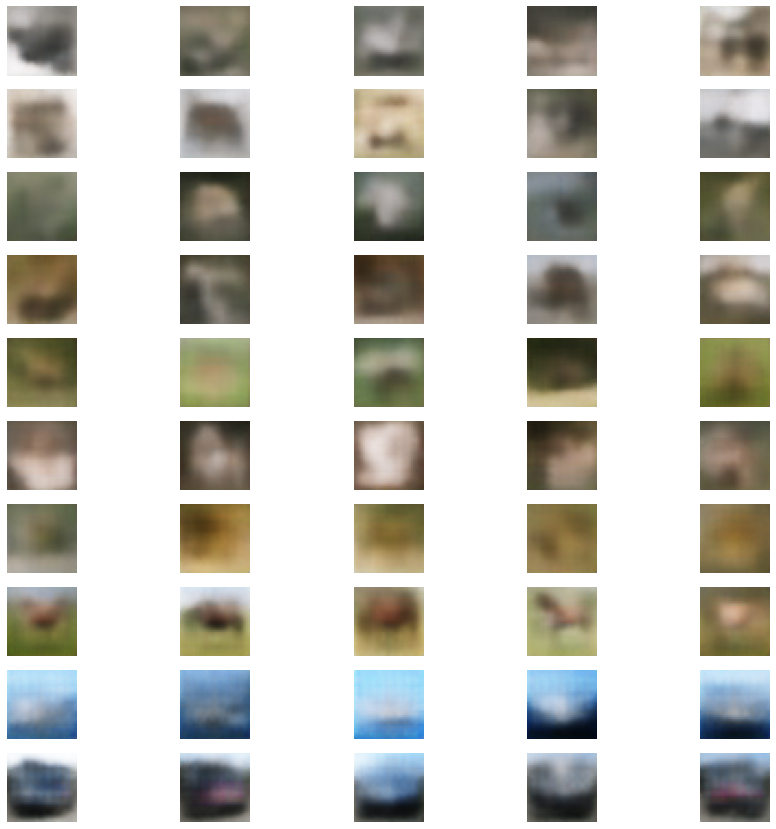

In [338]:
cond_sampled_im_mean_np = sess.run(cond_sampled_im_mean)
# Show the sampled images.
plt.figure(figsize=(15, 15))
global_idx = 0
for digit in range(10):
    for _ in range(5):
        ax = plt.subplot(10, 5, global_idx + 1)
        plt.imshow(cond_sampled_im_mean_np[global_idx, :].reshape(image_size, image_size, num_channels))
        ax.axis('off')
        global_idx += 1
plt.show()

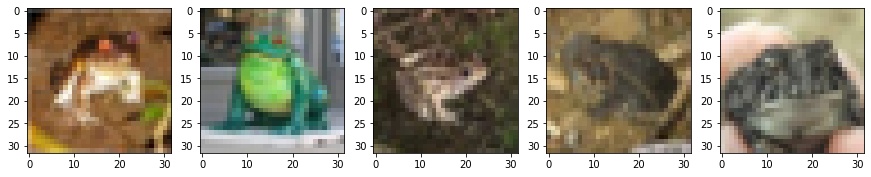

In [345]:
fig, ax = plt.subplots(1, 5, figsize=(15, 15))

n = 0
for j in range(len(x_train)):
  if y_train[j] == 6:
    ax[n].imshow(x_train[j, :])
    n +=1
    if n == 5:
      break